This is the driver program for the ARIMA process. 

- It starts with testing stationarity.
- Then it runs a grid search for the best parameters. It returns the best parameters and we use those going forward.
- Then we summarize residual errors for the model.
- Then we summarize residual errors from bias corrected forecasts.
- Plots test vs prediction scores
- Saves finalized model to file
- Loads the finalized model and makes a prediction. This proves that it works.
- Then finally we forecast for the balance of the year.

Update the John Holkins, Covid-19 data https://github.com/CSSEGISandData/COVID-19 by refreshing your local copy of the GitHub repository. 

In [15]:
# import libraries
import numpy as np
import pandas as pd
import pickle
import stationarity as st
import load_data as ld
import arima_grid_search as ags
import summarize
import test_prediction_save_forecast_1day as tpsf1
import multi_step_forecast as msf

In [16]:
# Prepare arguments for driver
arg_dict = {'file_name_1': r'data\all_df.csv',
            'file_name_2': r'C:\Users\linds\OneDrive\mystuff\GitHub\covid\data\country_codes_edited.csv',
            'feature': 'Alpha_3',
            'place': 'BRA',
            'dependent_variable': 'Deaths',
            'path': r'C:\Users\linds\OneDrive\mystuff\GitHub\COVID-19\csse_covid_19_data\csse_covid_19_daily_reports',
            'best_cfg': (1,1,0), # I initially tried p,d,q of 7,2,0 based on the ACF and PACF. It did not converge.
            'p_values': range(0,3),
            'd_values': range(0,3),
            'q_values': range(0,3),
            'split_value': .5,
            'bias': 0, # First time thru bias is 0
            'date': '12-31-2020'}

The "data date" is 2020-06-16 00:00:00

ADF Statistic: -0.649094
p-value: 0.859499
Critical Values:
	1%: -3.513
	5%: -2.897
	10%: -2.586


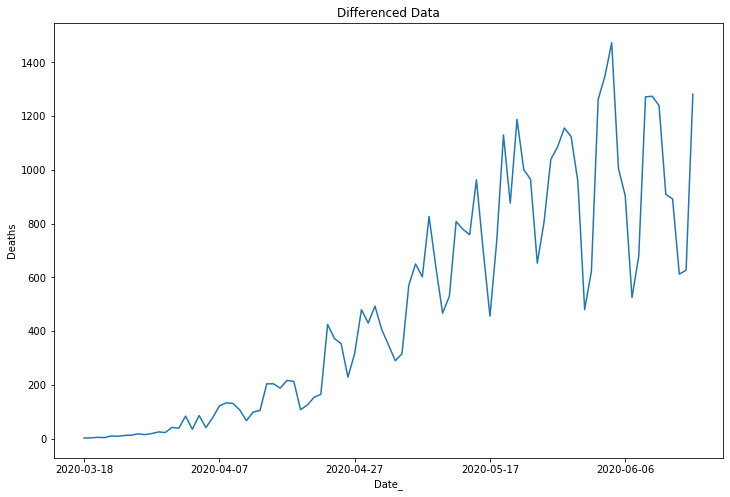

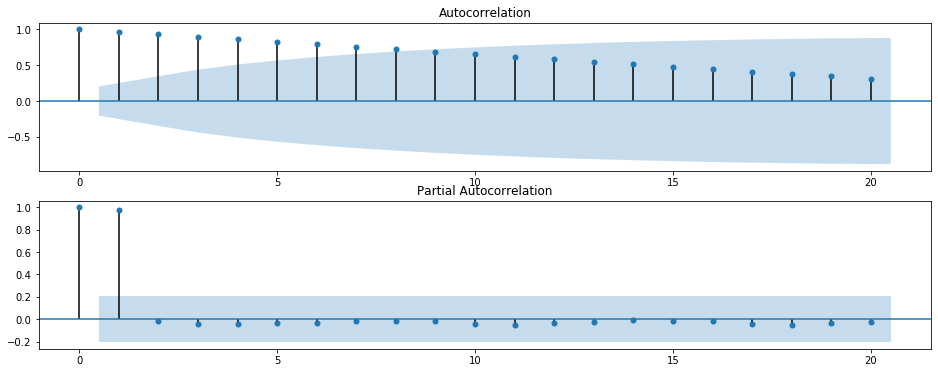

ARIMA(0, 0, 1) RMSE=13597.099
ARIMA(0, 0, 2) RMSE=7513.633
ARIMA(0, 1, 1) RMSE=542.043
ARIMA(0, 1, 2) RMSE=404.487
ARIMA(0, 2, 1) RMSE=275.223
ARIMA(0, 2, 2) RMSE=240.881
ARIMA(1, 0, 0) RMSE=896.901
ARIMA(1, 1, 0) RMSE=263.366
ARIMA(1, 2, 0) RMSE=265.589
ARIMA(1, 2, 2) RMSE=243.654
ARIMA(2, 1, 0) RMSE=267.973
ARIMA(2, 2, 0) RMSE=266.923
ARIMA(2, 2, 1) RMSE=237.757
Best ARIMA(2, 2, 1) RMSE=237.757
RMSE: 237.757
                0
count   46.000000
mean    30.464105
std    238.402355
min   -487.362877
25%   -108.209678
50%     25.343608
75%    175.761393
max    532.352050


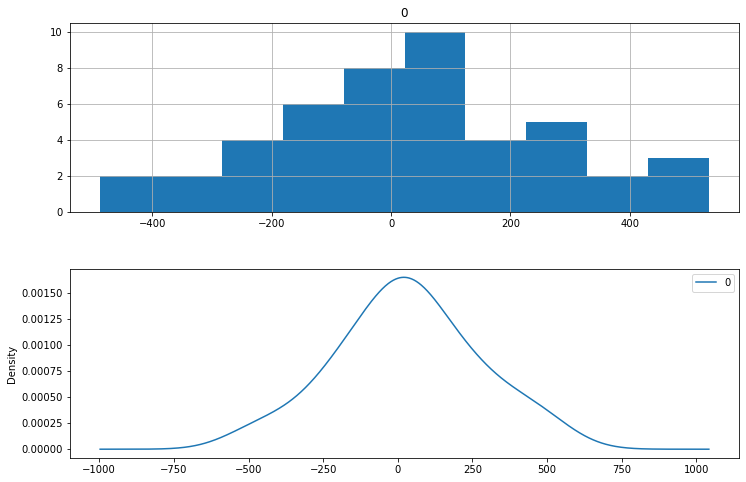


bias IS saved in arg_dict["bias"] for subsequent run is: 30.464105395350522 

RMSE: 235.797
                  0
count  4.600000e+01
mean  -2.372595e-13
std    2.384024e+02
min   -5.178270e+02
25%   -1.386738e+02
50%   -5.120498e+00
75%    1.452973e+02
max    5.018879e+02


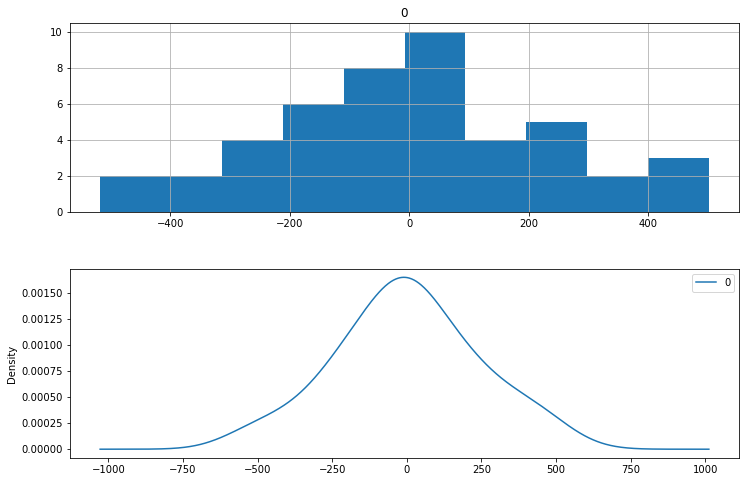


bias NOT saved in arg_dict["bias"] for subsequent run is: -2.3725948741902475e-13 



In [17]:
# Load John Hopkins data
df, li_set = ld.driver(arg_dict)

# Get the date of the last row in the file to establish the currency of the data.
print(f'The "data date" is {df["Date_"].iloc[-1]}\n')

# save arg_dict for subsequent independent processing
with open('arg_dict.pickle', 'wb') as handle:
    pickle.dump(arg_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Test for stationarity
df = st.driver(arg_dict)

# save df for subsequent independent processing
df.to_csv('df.csv')
      
# Grid search ARIMA parameters 
best_cfg = ags.driver(df, arg_dict)
arg_dict.update({'best_cfg': best_cfg})

# summarize residual errors for an ARIMA model and return bias
model_fit, test, predictions = summarize.driver(df, arg_dict)

# Rerun summarize, as bias adjusted
model_fit, test, predictions = summarize.driver(df, arg_dict)
arg_dict.update({'test': test, 'predictions': predictions, 'model_fit': model_fit})

# save arg_dict for subsequent independent processing
with open('arg_dict.pickle', 'wb') as handle:
    pickle.dump(arg_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)


The predicted cumulative Deaths for BRA for tomorrow (input data plus 1 day) are 44,802


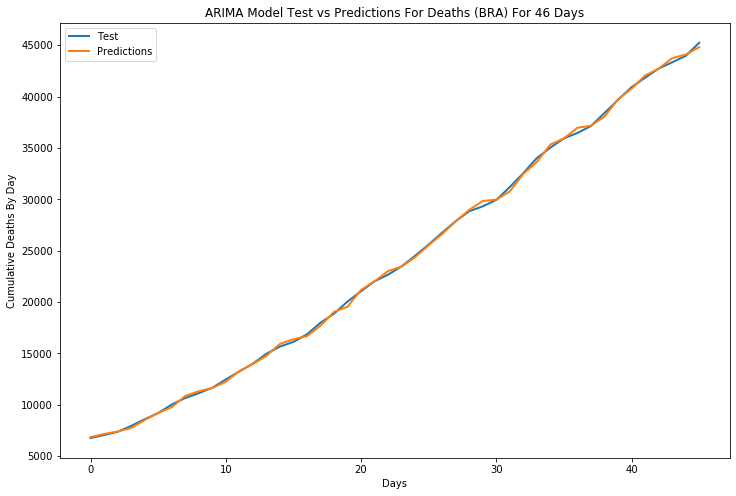

In [18]:
# Plot test (actual) vs predictions, save, and forecast
tpsf1.driver(arg_dict)

NB The above prediction of a single day in the future will only rarely match the the first day in the multi step forecast below. The reason is that the ARIMA model is a moving average model. The specific days included in the moving average change in the multi step forecast. 

The BRA prediction is for 511,304 cumulative Deaths to occur by 2020-12-31 00:00:00


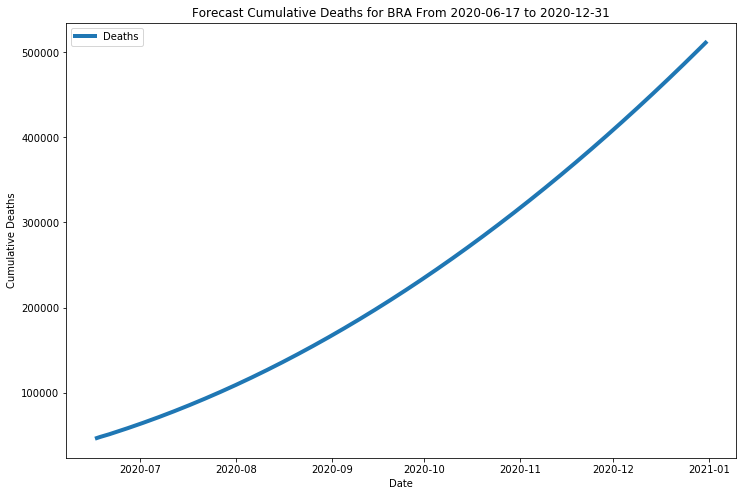

In [19]:
# Multi step forecast
df.index = pd.to_datetime(df.index)
forecast_df = msf.driver(df, arg_dict)

If the arg_dict has a prediction date later than the above date, the reason is that ARIMA expects the jurisdiction to have no more instances by the date indicated. We truncate the prediction at that point. 

In [20]:
new_col = "Daily_" + arg_dict['dependent_variable']
df[new_col] = df[arg_dict['dependent_variable']] - df[arg_dict['dependent_variable']].shift()
print('Actual')
df.tail() 

Actual


,Deaths,Daily_Deaths
Date_,,
2020-06-12,41828.0,909.0
2020-06-13,42720.0,892.0
2020-06-14,43332.0,612.0
2020-06-15,43959.0,627.0
2020-06-16,45241.0,1282.0


In [21]:
forecast_df[new_col] = forecast_df[arg_dict['dependent_variable']] - forecast_df[arg_dict['dependent_variable']].shift()
forecast_df.iloc[0,1] = forecast_df.iloc[0,0] - df.iloc[-1,0]
print('Predicted')
forecast_df.head()

Predicted


,Deaths,Daily_Deaths
Date_,,
2020-06-17,46684.0,1443.0
2020-06-18,47906.0,1222.0
2020-06-19,48962.0,1056.0
2020-06-20,50004.0,1042.0
2020-06-21,51120.0,1116.0
